# <center>  Heart Sound Classification </center> 
## <center> Heart murmur detection from Phonocardiogram recordings: [The George B. Moody PhysioNet Challenge 2022](https://moody-challenge.physionet.org/2022/)
In this notebook we train a baseline model to identify the  presence, absence, or unclear cases of murmurs in heart sound recordings collected from multiple auscultation locations on the body using a digital stethoscope.

<div style="width:100%;text-align: center;"> <img align=middle src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11277-020-07116-5/MediaObjects/11277_2020_7116_Fig1_HTML.png" alt="Heart beating" style="height:500px;margin-top:3rem;"> </div>
<center> Figure is taken from Had, A. et al 2020 </center> 


From a technical perspective, we will also investigate how we can accelerate the training prosess using TPUs and the Tensorflow Dataset functionality

## 📥 Import the necessary Python packages

In [1]:
import os
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as display
import tensorflow_addons as tfa
from scipy import signal
from IPython.display import clear_output
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

import jax.numpy as jnp

2022-02-11 16:59:06.264527: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-11 16:59:06.264632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# We import a utility script were we have some helping functions
import george_moody_challenge_2022_utility_script as gmc

In [3]:
# AT this point we use TensorFlow version 2.4.1 because may cause trouble for us regarding the TPU
print(tf.__version__)

2.4.1


In [4]:
# Path to the training data

data_path="../input/the-circor-digiscope-phonocardiogram-dataset/the-circor-digiscope-phonocardiogram-dataset-1.0.1/training_data"

## 🔩 Define our TPU strategy 

In [5]:
# Set TPU usage as our strategy

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

2022-02-11 16:59:12.854727: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-11 16:59:12.858236: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-11 16:59:12.858272: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-11 16:59:12.858300: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (61cc1e9d37c2): /proc/driver/nvidia/version does not exist
2022-02-11 16:59:12.860937: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


## 📥 Load the data

In [6]:
# store all filenames in the training data folder into one variable

patient_files = gmc.find_patient_files(data_path)
num_patient_files = len(patient_files)
num_patient_files

942

In [7]:
# The 3 classes used in the prediction model will be:

classes = ['Present', 'Unknown', 'Absent']
num_classes = len(classes)

In [8]:
# Resample all sound recordings from 4000Hz to 500Hz and save the data into a list (data) containing all sound recordings. 
# Load the ground truth for each sound recording into the labels-list

data = []
labels = list()
new_freq = 500

for i in tqdm.tqdm(range(num_patient_files)):
    # Load the current patient data and recordings.
    current_patient_data = gmc.load_patient_data(patient_files[i])
    current_recordings, freq = gmc.load_recordings(data_path, current_patient_data, get_frequencies=True)
    
    for j in range(len(current_recordings)):
        
        resamp_sig = signal.resample(current_recordings[j], int((len(current_recordings[j])/freq[j]) * new_freq))
        data.append(resamp_sig)

        # Extract labels and use one-hot encoding.
        current_labels = np.zeros(num_classes, dtype=int)
        label = gmc.get_label(current_patient_data)
        if label in classes:
            j = classes.index(label)
            current_labels[j] = 1
        labels.append(current_labels)

labels = np.vstack(labels)
data_numpy = np.asarray(data)
print(f"Number of signals = {data_numpy.shape[0]}")

100%|██████████| 942/942 [00:55<00:00, 17.10it/s]

Number of signals = 3163



/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [9]:
# Loop through all data and find the sound recording lengths

sig_len = []
for i in tqdm.tqdm(data):
    sig_len.append(len(i))
    
np.asarray(sig_len).max()

100%|██████████| 3163/3163 [00:00<00:00, 896875.58it/s]


32256

## 🔧 Preprocess the data

In [10]:
# Zero-pad all sound recordings so they get equally long as the longest one

data_padded = np.zeros((data_numpy.shape[0],np.asarray(sig_len).max()))
for i in tqdm.tqdm(range(data_numpy.shape[0])):
    data_padded [i] = tf.keras.preprocessing.sequence.pad_sequences(np.expand_dims(data_numpy[i],0),
                                                                    maxlen=np.asarray(sig_len).max(),
                                                                    padding='post',truncating='post', value=0.0)


100%|██████████| 3163/3163 [00:02<00:00, 1070.16it/s]


In [11]:
# The prevalence of the 3 different labels

print(f"Present = {np.where(np.argmax(labels,axis=1)==0)[0].shape[0]}, Unknown = {np.where(np.argmax(labels,axis=1)==1)[0].shape[0]}, Absent = {np.where(np.argmax(labels,axis=1)==2)[0].shape[0]}")

Present = 616, Unknown = 156, Absent = 2391


In [12]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        #clear_output(wait=True)
        #plt.plot(self.x, self.losses, label="loss")
        #plt.plot(self.x, self.val_losses, label="val_loss")
        #plt.legend()
        #plt.show();
    def on_train_end(self, epoch, logs={}):
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

plot_losses = PlotLosses()

In [13]:
from tensorflow import keras


def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True, kernel_size=40, bottleneck_size=32, nb_filters=32):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,
                                              padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                              strides=stride, padding='same', activation=activation, use_bias=False)(
            input_inception))

    max_pool_1 = keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = keras.layers.Conv1D(filters=nb_filters, kernel_size=1,
                                  padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = keras.layers.Concatenate(axis=2)(conv_list)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation='relu')(x)
    return x

def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                      padding='same', use_bias=False)(input_tensor)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    x = keras.layers.Add()([shortcut_y, out_tensor])
    x = keras.layers.Activation('relu')(x)
    return x

def build_model(sig_len,n_features, nb_classes, depth=6, use_residual=True):
    input_layer = keras.layers.Input(shape=(sig_len,n_features))

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = keras.layers.GlobalAveragePooling1D()(x)

    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    #model.compile(loss=[macro_double_soft_f1], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tfa.metrics.F1Score(num_classes=3, threshold= 0.5, name='f1_score')])
    return model



In [14]:
def inception_block(prev_layer):
    
    conv1=tf.keras.layers.Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=tf.keras.layers.BatchNormalization()(conv1)
    conv1=tf.keras.layers.Activation('relu')(conv1)
    #conv1=tf.keras.layers.SpatialDropout1D(rate=0.2)(conv1)
    
    conv3=tf.keras.layers.Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=tf.keras.layers.BatchNormalization()(conv3)
    conv3=tf.keras.layers.Activation('relu')(conv3)
    conv3=tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=tf.keras.layers.BatchNormalization()(conv3)
    conv3=tf.keras.layers.Activation('relu')(conv3)
    #conv3=tf.keras.layers.SpatialDropout1D(rate=0.2)(conv3)
    
    conv5=tf.keras.layers.Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=tf.keras.layers.BatchNormalization()(conv5)
    conv5=tf.keras.layers.Activation('relu')(conv5)
    conv5=tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=tf.keras.layers.BatchNormalization()(conv5)
    conv5=tf.keras.layers.Activation('relu')(conv5)
    #conv5=tf.keras.layers.SpatialDropout1D(rate=0.2)(conv5)
    
    pool= tf.keras.layers.MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=tf.keras.layers.Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=tf.keras.layers.BatchNormalization()(convmax)
    convmax=tf.keras.layers.Activation('relu')(convmax)
    #convmax=tf.keras.layers.SpatialDropout1D(rate=0.2)(convmax)
    
    layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(sig_len,n_features, output):
    input_layer = tf.keras.layers.Input(shape=(sig_len,n_features)) 
    
    X = tf.keras.layers.ZeroPadding1D(3)(input_layer)
    
    X = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)

    
    X = inception_block(X)
    X = inception_block(X)
    
    
    X = tf.keras.layers.MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = tf.keras.layers.GlobalAveragePooling1D()(X)
    
    
    output_layer = tf.keras.layers.Dense(units=output,activation='softmax')(X)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tfa.metrics.F1Score(num_classes=3, threshold= 0.5, name='f1_score')])

    return model

In [15]:
from sklearn.utils.class_weight import compute_class_weight
def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1_score', factor=0.1, patience=3, verbose=1, mode='min',
    min_delta=0.0001, cooldown=5, min_lr=0
)

## 💡 This is why we use TPU for this problem

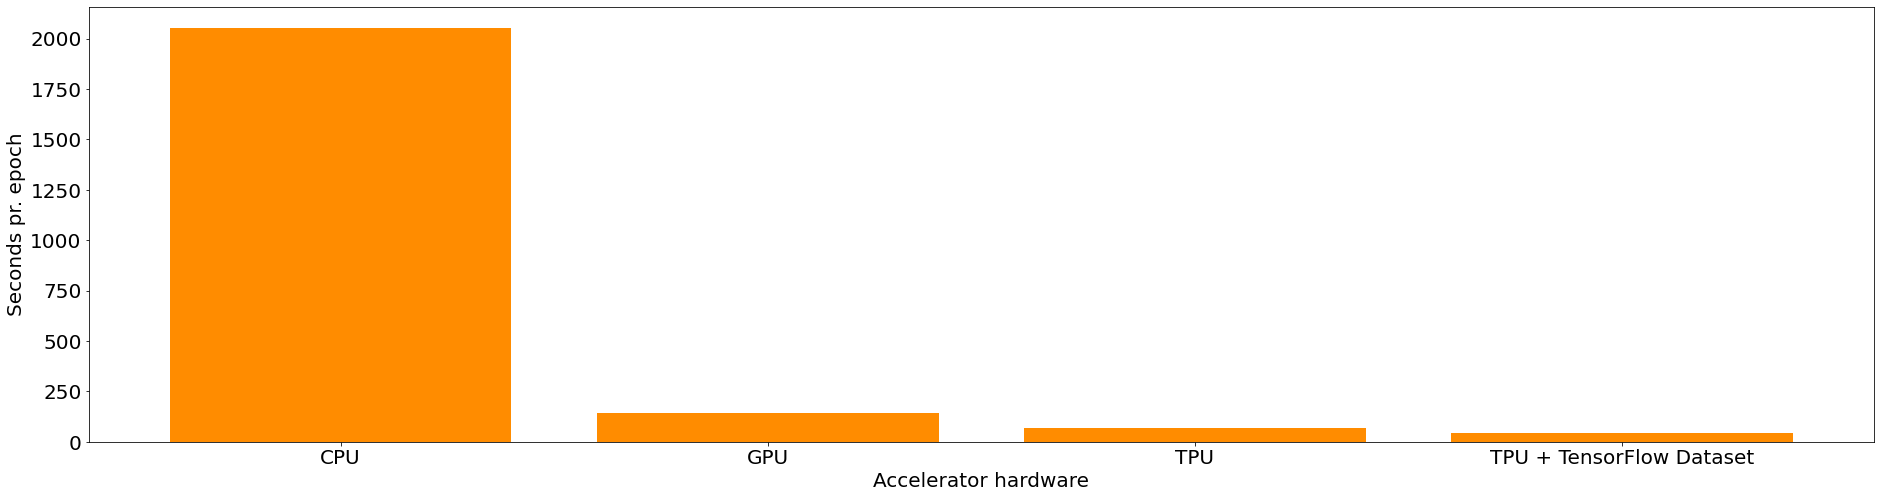

In [17]:
plt.figure(figsize=(32,8))
plt.bar(["CPU", "GPU", "TPU", "TPU + TensorFlow Dataset"], [2054, 142, 70, 42], color="darkorange")
plt.xlabel("Accelerator hardware",fontsize=20)
plt.ylabel("Seconds pr. epoch",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## ⏳ Train the model

CV fold 1


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0.0, 1.0], y=[1 1 1 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


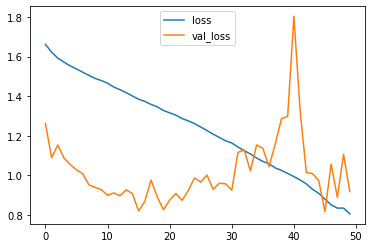

22/22 [==============================] - 2s 60ms/step - loss: 0.9175 - accuracy: 0.7846 - f1_score: 0.3270
Training loss = 0.9174818992614746, Validation loss = 0.7846235036849976, 
Validation accuaracy class 1 = 0.0317460335791111, 
Validation accuaracy class 2 = 0.13445378839969635, 
Validation accuaracy class 3 = 0.8148893117904663
CV fold 2


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0.0, 1.0], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


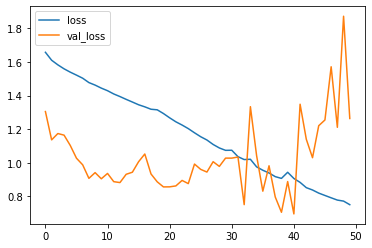

22/22 [==============================] - 2s 60ms/step - loss: 1.2633 - accuracy: 0.7583 - f1_score: 0.3377
Training loss = 1.2633212804794312, Validation loss = 0.758293867111206, 
Validation accuaracy class 1 = 0.0625, 
Validation accuaracy class 2 = 0.1547619253396988, 
Validation accuaracy class 3 = 0.795854926109314
CV fold 3


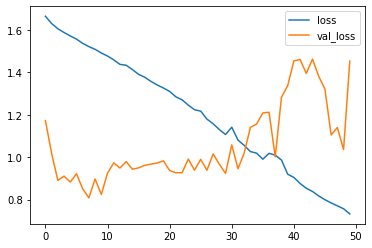

22/22 [==============================] - 3s 60ms/step - loss: 1.4531 - accuracy: 0.4265 - f1_score: 0.0561
Training loss = 1.453071117401123, Validation loss = 0.4265402853488922, 
Validation accuaracy class 1 = 0.03200000151991844, 
Validation accuaracy class 2 = 0.11171169579029083, 
Validation accuaracy class 3 = 0.024640655145049095
CV fold 4


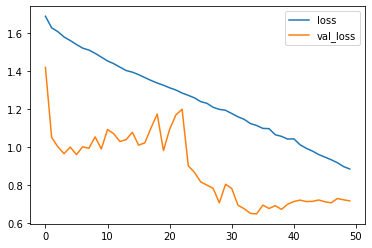

22/22 [==============================] - 2s 60ms/step - loss: 0.7180 - accuracy: 0.8470 - f1_score: 0.3700
Training loss = 0.7180379033088684, Validation loss = 0.847046434879303, 
Validation accuaracy class 1 = 0.24000002443790436, 
Validation accuaracy class 2 = 0.0, 
Validation accuaracy class 3 = 0.8699719309806824
CV fold 5


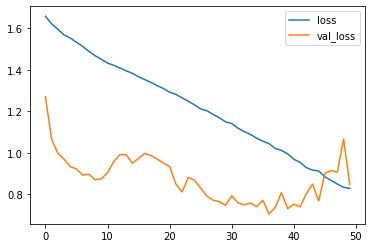

22/22 [==============================] - 2s 60ms/step - loss: 0.8481 - accuracy: 0.6809 - f1_score: 0.3330
Training loss = 0.8480948805809021, Validation loss = 0.680907130241394, 
Validation accuaracy class 1 = 0.41900646686553955, 
Validation accuaracy class 2 = 0.0, 
Validation accuaracy class 3 = 0.5801105499267578


In [18]:
# Validate the model using 5-fold stratified CV (startification based on the ground truth labels)
folds = 5
batch_size = 30
n_epochs = 50
cnt=0
skf = StratifiedKFold(n_splits=folds)
for train_index, val_index in skf.split(data_padded, np.argmax(labels,axis=1)):
    cnt += 1
    print(f"CV fold {cnt}")
    # Split the development data into train and validation
    X_train, X_val = data_padded[train_index], data_padded[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Use the prevalence of each class to weight the learning of the different samples/recordings -> lower prevalence = higher weight
    new_weights=calculating_class_weights(y_train)
    keys = np.arange(0,y_train.shape[1],1)
    weight_dictionary = dict(zip(keys, new_weights.T[1]))
    
    # Assign the training data to a Tensorflow dataset 
    tf_dataset_train = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_train,2), np.asarray(y_train)))
    tf_dataset_train = tf_dataset_train.cache()
    tf_dataset_train = tf_dataset_train.batch(batch_size)
    tf_dataset_train = tf_dataset_train.prefetch(tf.data.AUTOTUNE)
    
    # Assign the validation data to a Tensorflow dataset 
    tf_dataset_val = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_val,2), np.asarray(y_val)))
    tf_dataset_val = tf_dataset_val.cache()
    tf_dataset_val = tf_dataset_val.batch(batch_size)
    tf_dataset_val = tf_dataset_val.prefetch(tf.data.AUTOTUNE) 
    
    # Use our TPU strategy when we finally train the model
    with strategy.scope():
        model = build_model(data_padded.shape[1],1,labels.shape[1])
        #model = inception_model(data_padded.shape[1],1,labels.shape[1])
        model.fit(x=tf_dataset_train, epochs=n_epochs, 
                  validation_data=tf_dataset_val,  
                  callbacks = [plot_losses], verbose=0,
                  class_weight=weight_dictionary
                 )
        res = model.evaluate(tf_dataset_val)
        print(f"Training loss = {res[0]}, Validation loss = {res[1]}, \nValidation accuaracy class 1 = {res[2][0]}, \nValidation accuaracy class 2 = {res[2][1]}, \nValidation accuaracy class 3 = {res[2][2]}")